## Manifold Methods for Visualisation of High-dimensional Data
 
**Data** [Sources](2_Data_Sources.ipynb) | [Compositional Data](2_Data_CompositionalData.ipynb) | [Lambdas](2_Data_Lambdas.ipynb) **Classifiers** [Models](3_Classifiers_ClassifierModels.ipynb) | [Dimensionality](3_Classifiers_Dimensionality.ipynb) | [Performance](3_Classifiers_Performance.ipynb) **Visualisation**  [Entropy](4_Vis_Entropy.ipynb) | [Manifolds](4_Vis_Manifolds.ipynb) **Workflows** [Building Workflows](5_BuildingWorkflows.ipynb) **pyrolite** [Overview](6_pyrolite.ipynb) **GitHub** [AEGC2019](https://github.com/morganjwilliams/aegc2019) | [pyrolite](https://github.com/morganjwilliams/pyrolite)

Visualisation of data which has high dimensionality is challenging, and one solution is to provide visualisations in low-dimension representations of the space actually spanned by the data. Here we provide an example of visualisation of classification predictions and relative prediction certainty for a toy sklearn dataset (using entropy across predicted probability for each individual class, [adapted from pyrolite documentation](https://pyrolite.readthedocs.io/en/develop/usage/eg/plotting/manifold.html)).

In [1]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
from pyrolite.util.skl.pipeline import SVC_pipeline
from pyrolite.util.skl.vis import plot_mapping
from pyrolite.util.plot import __DEFAULT_DISC_COLORMAP__

np.random.seed(82)

Using TensorFlow backend.


In [2]:
wine = sklearn.datasets.load_wine()
data, target = wine["data"], wine["target"]

In [3]:
svc = SVC_pipeline(probability=True)
gs = svc.fit(data, target)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.1s finished


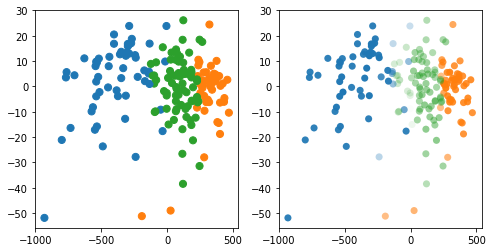

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

a, tfm, mapped = plot_mapping(
    data, gs.best_estimator_, ax=ax[1], s=50, init="pca"
)
ax[0].scatter(*mapped.T, c=__DEFAULT_DISC_COLORMAP__(gs.predict(data)), s=50);

### Visualising Classifier Boundaries

In [5]:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html